# Data Science project - OD Travel time Predictor
Students : Alix MEULOT, Anaëlle Marty, Ghislain MUTABAZI, Nathan DAMBREVILLE

## <u> **I/ Data preprocessing** </u>
###  <u> **0 - Imports** </u>
#### a/ Libraries import

In [1]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn import tree

print("✅ Libraries successfully imported")

✅ Libraries successfully imported


#### b/ `read_whole_pandas_df` function import

In [2]:
alt_path = 'data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv'

def read_whole_pandas_df(path, alternative_path=alt_path, sep = ",", enc = None, columns = None, parse_dates=None, format=None, alternative_dataset = False):
    if alternative_dataset:
        all_files = [alternative_path]
    else:
        all_files = glob.glob(path)
    li = []
    for filename in all_files:
        print("Reading file {}".format(filename))
        df = pd.read_csv(filename, encoding = enc, sep=sep, names = columns, header=0)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

print(f"✅ read_whole_pandas_df function successfully defined, with alternative_path set as:\n{alt_path}")

✅ read_whole_pandas_df function successfully defined, with alternative_path set as:
data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv


#### c/ Data import

In [3]:
BASE_PATH = r"data/"  #replace with base path to velo's data
LYON_PATH = BASE_PATH + r"VELO-LYON/Trajets VELOV */*.csv"
LYON_LOCATIONS = BASE_PATH + r"VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json"
LYON_IRIS = BASE_PATH + r"iris_lyon.shp"
LYON_CENTER = (45.764043, 4.835659)
df_lyon = read_whole_pandas_df(LYON_PATH, alternative_path=alt_path, sep = ";", enc = "ISO-8859-1", 
                               columns = ["id_exit_station", "exit_station", "date_exit", "id_return_station", "return_station", "date_return"], alternative_dataset=True)
print(f"✅ All datasets were successfully imported")

df_lyon["date_exit"] = pd.to_datetime(df_lyon['date_exit'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
df_lyon["date_return"] = pd.to_datetime(df_lyon['date_return'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
print(f"✅ The columns |date_exit| and |date_return| were successfully converted to datetime.")
df_lyon.head()

Reading file data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv
✅ All datasets were successfully imported
✅ All datasets were successfully imported
✅ The columns |date_exit| and |date_return| were successfully converted to datetime.
✅ The columns |date_exit| and |date_return| were successfully converted to datetime.


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00


###  <u> **1 - Adding intermediate columns** </u>
#### a/ Floored datetime column

In [4]:
df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")
df_lyon.head()

C:\Users\ndamb\AppData\Local\Temp\ipykernel_2692\2808807517.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,2019-04-01 00:00:00+02:00
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,2019-04-01 00:00:00+02:00
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,2019-04-01 00:00:00+02:00


#### b/ `day`, `month`, and `travel_time` columns
**NB:** The travel time is computed in minutes.

In [5]:
df_lyon['day'] = df_lyon.date_exit.dt.day_of_week
df_lyon['month'] = df_lyon.date_exit.dt.month
df_lyon['travel_time'] =  (df_lyon.date_return-df_lyon.date_exit).dt.total_seconds()/60
df_lyon.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,2019-04-01 00:00:00+02:00,0,4,28.0
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,2019-04-01 00:00:00+02:00,0,4,14.0
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,2019-04-01 00:00:00+02:00,0,4,4.0


###  <u> **2 - Adding the `distance` column** </u>

In [6]:
gdf_stations = gpd.read_file(LYON_LOCATIONS)
gdf_stations.to_crs('2154', inplace=True)

coords = np.array([[geom.x, geom.y] for geom in gdf_stations.geometry.centroid])
dist_matrix = pairwise_distances(coords, metric="euclidean")
df_dist = pd.DataFrame(dist_matrix, index=gdf_stations['idstation'], columns=gdf_stations['idstation'])
display(df_dist.head())

df_lyon = df_lyon[df_lyon.id_exit_station.isin(df_dist.index) & df_lyon.id_return_station.isin(df_dist.index)].copy()
row_idx = df_dist.index.get_indexer(df_lyon.id_exit_station)
col_idx = df_dist.columns.get_indexer(df_lyon.id_return_station)
df_lyon["distance"] = df_dist.to_numpy()[row_idx, col_idx]
df_lyon.head()

idstation,7024,10063,10021,8038,7045,6045,8056,8015,7057,7007,...,3035,6039,30002,12005,2027,3040,7017,3138,10049,10044
idstation,,,,,,,,,,,,,,,,,,,,,
7024,0.000000,3672.322221,4038.271301,2101.306115,1728.531155,2359.789599,1897.619990,2771.548411,1581.022503,1739.714329,...,1487.311727,2209.079367,8316.839400,7914.027093,1190.596433,1448.733485,1397.488839,1707.214746,4936.861621,5241.842046
10063,3672.322221,0.000000,367.937601,1918.014222,5276.485492,2393.483029,3362.975962,2193.760999,4699.773041,5159.729411,...,2185.076724,2763.907648,6395.079493,4458.602747,4860.315824,2233.220170,4667.580451,2109.599779,1478.056510,2520.604551
10021,4038.271301,367.937601,0.000000,2269.206815,5644.183932,2665.024201,3700.574285,2477.416757,5062.122623,5525.999425,...,2550.967781,3042.980467,6250.871362,4115.750370,5225.466883,2596.741636,5032.708705,2457.739820,1175.815415,2354.611591
8038,2101.306115,1918.014222,2269.206815,0.000000,3484.503141,2327.918947,1467.055847,883.373258,2817.475111,3322.282657,...,940.820395,2518.623358,7840.242909,6376.168575,3252.453650,1066.873708,2814.886550,1368.271058,3379.142600,4169.994273
7045,1728.531155,5276.485492,5644.183932,3484.503141,0.000000,4061.439765,2522.986998,3875.840707,919.283986,340.362043,...,3133.747731,3865.225819,9954.924357,9612.529985,932.679947,3123.005262,758.389211,3425.591997,6614.809720,6970.331063


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,2019-04-01 00:00:00+02:00,0,4,28.0,4659.845582
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0,1629.727220
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0,1610.518885
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,2019-04-01 00:00:00+02:00,0,4,14.0,3446.325685
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,2019-04-01 00:00:00+02:00,0,4,4.0,807.072642


###  <u> **3 - Filtering** </u>

In [7]:
df_lyon = df_lyon[df_lyon.id_exit_station != df_lyon.id_return_station]
df_lyon = df_lyon[df_lyon.travel_time<30]
df_lyon = df_lyon[df_lyon.travel_time>0]
df_lyon.sample(10)

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance
1509293,5004,5004 - SAINT-JEAN,2019-06-01 08:17:00+02:00,2006.0,2006 - PLACE DE L'HIPPODROME,2019-06-01 08:26:00+02:00,2019-06-01 08:00:00+02:00,5,6,9.0,1671.607329
1457037,7041,7041 - DOMER / CHEVREUL,2019-05-29 21:31:00+02:00,7057.0,7057 - JAURES / BOLLIER,2019-05-29 21:39:00+02:00,2019-05-29 21:00:00+02:00,2,5,8.0,1498.283442
1580269,9011,9011 - CONSERVATOIRE,2019-06-04 11:14:00+02:00,9002.0,9002 - MAIRIE DU 9E,2019-06-04 11:19:00+02:00,2019-06-04 11:00:00+02:00,1,6,5.0,736.173075
883960,6028,6028 - RÉCAMIER / TÊTE D'OR,2019-05-07 08:31:00+02:00,2017.0,2017 - RÉPUBLIQUE / FERRANDIÈRE,2019-05-07 08:40:00+02:00,2019-05-07 08:00:00+02:00,1,5,9.0,1382.826747
1571844,9022,9022 - MASARYK / SAINT-CYR,2019-06-03 23:38:00+02:00,3087.0,3087 - PART-DIEU / GARIBALDI,2019-06-04 00:01:00+02:00,2019-06-03 23:00:00+02:00,0,6,23.0,3937.921347
66132,3039,3039 - PLACE BIR-HAKEIM,2019-04-03 08:41:00+02:00,6016.0,6016 - VIABERT / THIERS,2019-04-03 08:52:00+02:00,2019-04-03 08:00:00+02:00,2,4,11.0,1568.157687
1702414,7011,7011 - BERTHELOT / GARIBALDI,2019-06-09 00:36:00+02:00,7007.0,7007 - FARGE / AYASSE,2019-06-09 00:45:00+02:00,2019-06-09 00:00:00+02:00,6,6,9.0,1769.570947
879428,10120,10120 - SALENGRO / DESCARTES,2019-05-06 22:48:00+02:00,10002.0,10002 - INSA,2019-05-06 22:51:00+02:00,2019-05-06 22:00:00+02:00,0,5,3.0,781.216179
1952783,10039,10039 - BOUVIER,2019-06-21 17:50:00+02:00,6035.0,6035 - CITÉ INTERNATIONALE,2019-06-21 18:04:00+02:00,2019-06-21 17:00:00+02:00,4,6,14.0,2984.598054
825192,7064,7064 - CROUS,2019-05-04 09:03:00+02:00,3029.0,3029 - PLACE ARISTIDE BRIAND,2019-05-04 09:09:00+02:00,2019-05-04 09:00:00+02:00,5,5,6.0,862.675603


## <u> **II/ Regression modelling** </u>
###  <u> **1 - Model 0 // Simple linear regression** </u>
#### a/ Model definition

In [8]:
# STEP 1 - GIVE IT A NAME

y = df_lyon['travel_time']
X = df_lyon[['distance']]

# STEP 2 - GIVE IT A NAME

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# STEP 3 - GIVE IT A NAME AND COMMENT ON EACH LINE

model = LinearRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 

print(model.intercept_, model.coef_, )

# STEP 4 - GIVE IT A NAME
s_validation = pd.Series({
    'R²': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
})
s_validation

2.7416998321868142 [0.00490217]


R²      0.612275
MSE    14.436226
MAE     2.630258
dtype: float64

In [9]:
# Plotting a scatter graph of the travels' distance and duration (i.e. travel time) and the line of our regression model
## /!\ Code below runs in 5min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_lyon, alpha=0.1, label='Data points')
#sns.lineplot(x=X_test['distance'], y=y_pred, color='red', label='Regression line')
#plt.title('Travel Time vs Distance (with Regression Line)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

#### b/ Future functions

In [10]:
def my_train_test_split(X, Y, rate = 0.8):
    split_idx = int(len(X) * rate)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]
    return X_train, X_test, y_train, y_test

def build_coeffs_df(model):
    df_coeff = pd.DataFrame({
        'Coefficient': model.coef_
    }, index = X.columns)
    df_coeff.sort_values(by='Coefficient', ascending=False, inplace=True) 
    df_coeff = df_coeff.T
    df_coeff['intercept'] = model.intercept_
    df_coeff = df_coeff.T

    return df_coeff

def build_validation_serie(y_test, y_pred):
    s_validation = pd.Series({
        'R²': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
    })
    return s_validation

###  <u> **1 - Model 1 // Multiple linear regression** </u>
#### a/ Adding the day of the week parameter

In [11]:
# Extracting a subset of our original dataframe with only the columns at use
df_model1 = df_lyon[['distance', 'travel_time', 'datetime_1h', 'day', 'month']].copy()
df_model1.sample(5)

,distance,travel_time,datetime_1h,day,month
1092619,1769.605935,13.0,2019-05-16 07:00:00+02:00,3,5
1302624,1092.896274,6.0,2019-05-24 07:00:00+02:00,4,5
860002,924.368623,4.0,2019-05-06 09:00:00+02:00,0,5
1556248,2755.388058,18.0,2019-06-03 13:00:00+02:00,0,6
1131296,751.369333,5.0,2019-05-17 12:00:00+02:00,4,5


In [12]:
# Creating a dataframe with the columns distance, travel_time, and dummies representing the day of the week
df_model1_dummies = pd.get_dummies(df_model1, columns=['day'], drop_first=True, dtype="int")
df_model1_dummies.sample(5)

,distance,travel_time,datetime_1h,month,day_1,day_2,day_3,day_4,day_5,day_6
1499982,1889.931081,9.0,2019-05-31 19:00:00+02:00,5,0,0,0,1,0,0
1175444,1265.112761,6.0,2019-05-19 15:00:00+02:00,5,0,0,0,0,0,1
543688,685.510519,4.0,2019-04-22 14:00:00+02:00,4,0,0,0,0,0,0
1443072,2734.378611,14.0,2019-05-29 13:00:00+02:00,5,0,1,0,0,0,0
517311,2588.511818,22.0,2019-04-20 19:00:00+02:00,4,0,0,0,0,1,0


,Coefficient
day_5,1.027371
day_6,0.886977
day_2,0.285906
day_4,0.283732
day_3,0.112139
day_1,0.056494
distance,0.004896
intercept,2.435412


R²      0.615426
MSE    14.318934
MAE     2.623344
dtype: float64

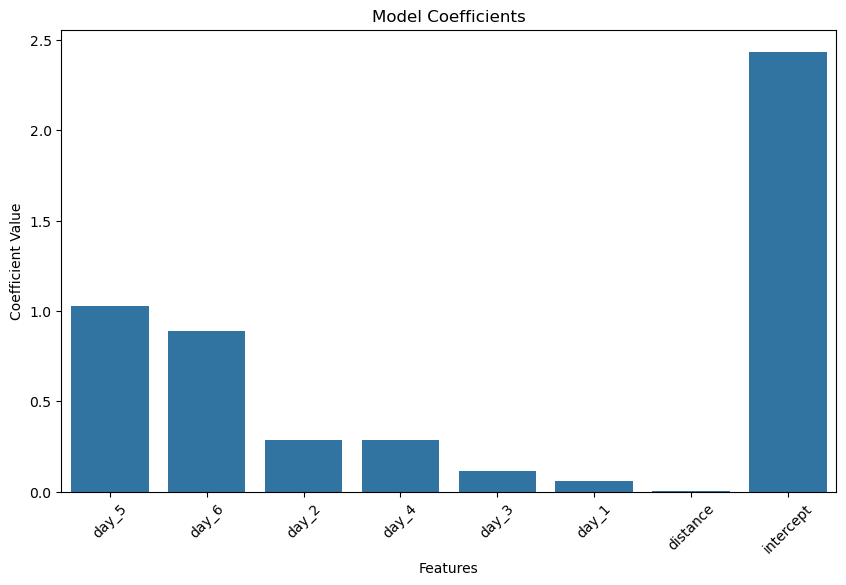

In [13]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model1_dummies['travel_time']
X = df_model1_dummies.drop(columns=['month', 'datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model1_day = LinearRegression()
model1_day.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1 = model1_day.predict(X_test)
s_model1_validation = build_validation_serie(y_test, y_pred_model1)
display(s_model1_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

## Plotting a scatter graph of the travels' distance and duration (i.e. travel time)
## and the lines of our multi-linear regression model, with different colors for each day of the week
## /!\ Code below runs in 15min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_model1_dummies, alpha=0.01, label='Data points')
#for day in range(1, 7):
#    day_columns = [col for col in X_test.columns if col.startswith('day_')]
#    day_dummies = np.zeros((len(X_test), len(day_columns)))
#    if day - 1 < len(day_columns):
#        day_dummies[:, day - 1] = 1
#    X_temp = X_test.copy()
#    X_temp[day_columns] = day_dummies
#    y_pred_day = model1_day.predict(X_temp)
#    sns.lineplot(x=X_test['distance'], y=y_pred_day, label=f'Day {day}')
#plt.title('Travel Time vs Distance (with Regression Lines for Each Day)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

#### b/ Adding the time of day parameter

In [14]:
# Adding the dummies column indicating which hour of the day it is
df_model1['hour'] = df_model1['datetime_1h'].dt.hour
df_model1_dummies_hour = pd.get_dummies(df_model1, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model1_dummies_hour.sample(5)

,distance,travel_time,datetime_1h,month,day_1,day_2,day_3,day_4,day_5,day_6,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
615748,2063.633052,10.0,2019-04-25 18:00:00+02:00,4,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1762642,1687.988381,13.0,2019-06-13 08:00:00+02:00,6,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
808874,2563.361791,11.0,2019-05-03 16:00:00+02:00,5,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2142326,386.103654,5.0,2019-06-30 23:00:00+02:00,6,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
256496,1780.054171,10.0,2019-04-10 16:00:00+02:00,4,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


,Coefficient
day_5,0.875782
day_6,0.712004
hour_15,0.559798
hour_16,0.492259
hour_2,0.410255
hour_1,0.342070
hour_3,0.340231
hour_17,0.283549
day_4,0.275069
day_2,0.273714


R²      0.620551
MSE    14.128103
MAE     2.601710
dtype: float64

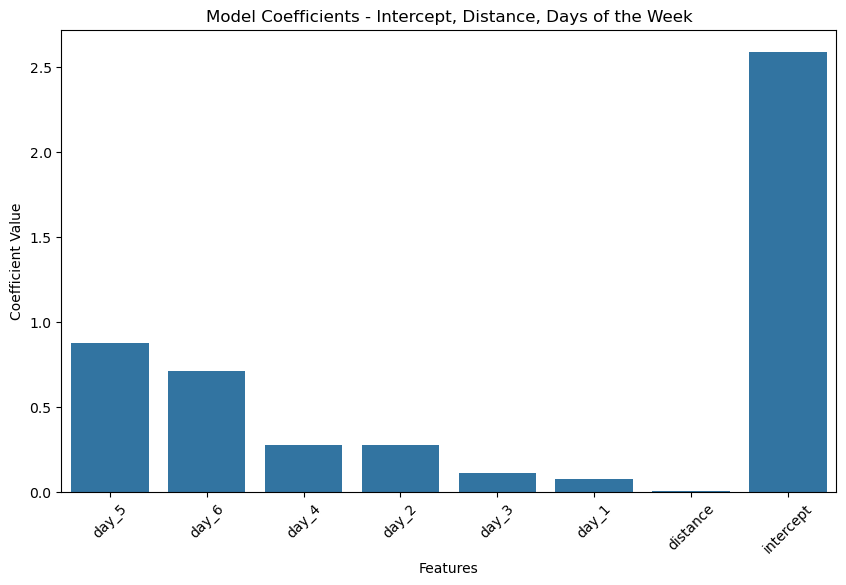

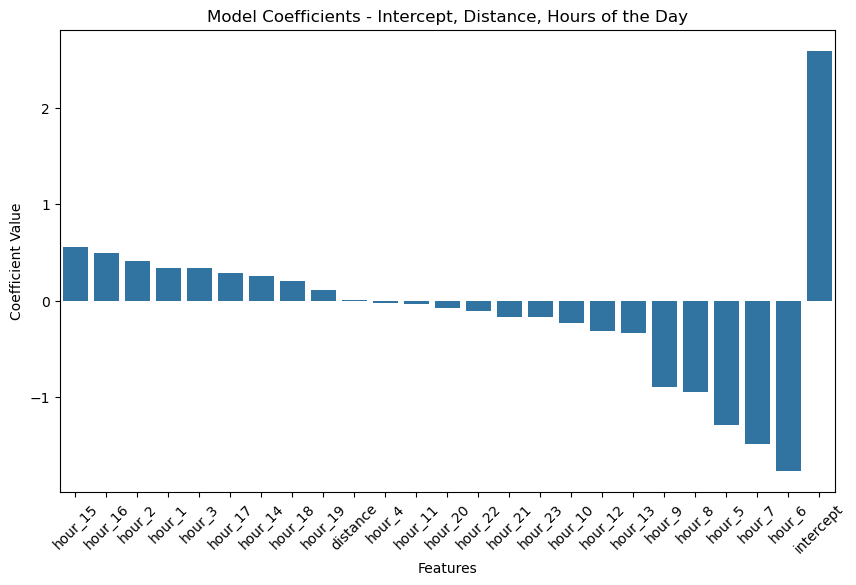

C:\Users\ndamb\AppData\Local\Temp\ipykernel_2692\2760248447.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)


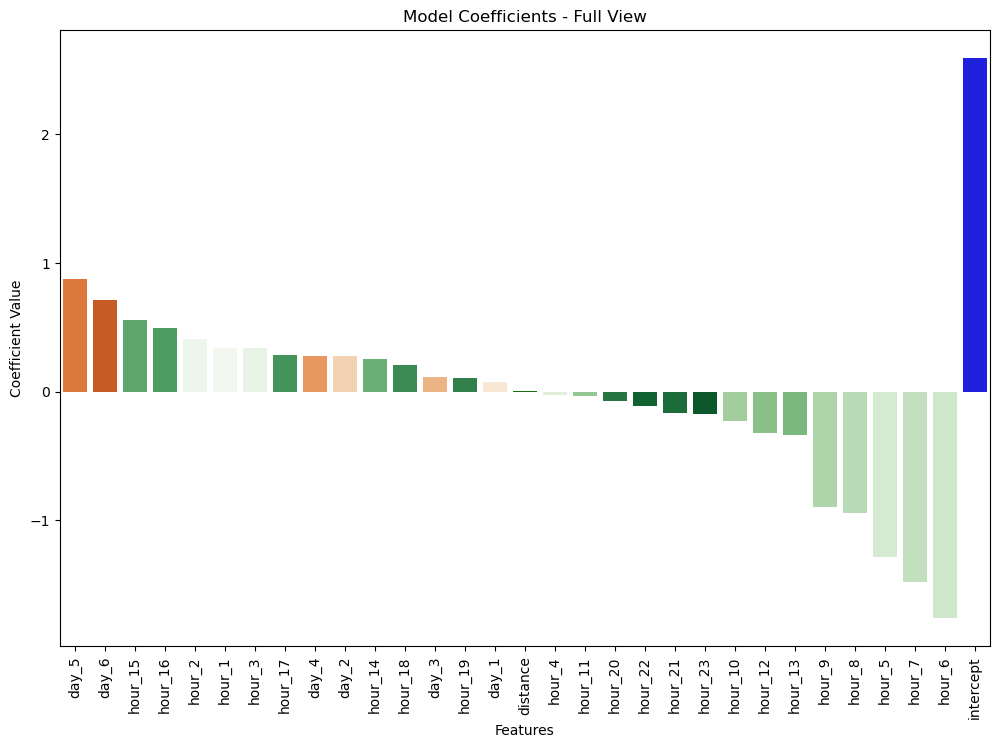

In [15]:
# Creating our multi-linear regression model, predicting the travel time based on the previous parameters and the hour of the day
## Splitting our data using my_train_test_split function
y = df_model1_dummies_hour['travel_time']
X = df_model1_dummies_hour.drop(columns=['month', 'datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our new model 1: model1_day_hour
model1_day_hour = LinearRegression()
model1_day_hour.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day_hour)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1_day_hour = model1_day_hour.predict(X_test)
s_model1_day_hour_validation = build_validation_serie(y_test, y_pred_model1_day_hour)
display(s_model1_day_hour_validation)

## Plotting 3 bar plots of the model's coefficients
### Plotting the first bar plot with the intercept, the distance and the days of the week
df_days = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('day_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_days.index, y='Coefficient', data=df_days.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Days of the Week')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the second bar plot with the intercept, the distance and the hours of the day
df_hours = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('hour_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_hours.index, y='Coefficient', data=df_hours.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Hours of the Day')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the last bar plot with all the coefficients and setting 2 different colors
### for the intercept and the distance, and setting 2 different gradient for the hours of the day
### and the days of the week
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model1_coeffs.index:
    if idx == 'intercept':
        colors.append('blue')
    elif idx == 'distance':
        colors.append('green')
    elif idx.startswith('day_'):
        colors.append(plt.cm.Oranges(int(idx.split('_')[1]) * 30))
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    else:
        colors.append('gray')
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()